In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from scipy.stats import randint, uniform, loguniform
import time  # Just to compare fit times

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv 
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Import data

In [3]:
load_dotenv(dotenv_path="../.env")
UNCLEAN_FFT_FILE_PATH = os.getenv("UNCLEAN_FFT_DATA_PATH")
CLEAN_FFT_DATA_PATH_AP1 = os.getenv("CLEAN_FFT_DATA_PATH_AP1")
CLEAN_FFT_DATA_PATH_AP2 = os.getenv("CLEAN_FFT_DATA_PATH_AP2")

train_path = CLEAN_FFT_DATA_PATH_AP1 + "/train_dataset"
validation_path = CLEAN_FFT_DATA_PATH_AP1 + "/validation_dataset"

print(train_path)
print(validation_path)

/home/mrcong/code/python/nilm_cong_son/data/clean_data/approach1/fft_data/train_dataset
/home/mrcong/code/python/nilm_cong_son/data/clean_data/approach1/fft_data/validation_dataset


In [4]:
def count_labels_in_directory(dir_path: str):
    # Define the prefixes
    prefixes = ['error', 'normal', 'zero', 'overcurrent', 'overheating']

    # Count files for each prefix
    file_counts = {}

    for prefix in prefixes:
        pattern = f"{dir_path}/{prefix}_*"
        files = glob.glob(pattern)
        file_counts[prefix] = len(files)

    # Print the results
    for prefix, count in file_counts.items():
        print(f"There are {count} files with the prefix '{prefix}' in the directory.")
        
def read_data_from_dir(dir_path):
    # Initialize lists to store data
    amplitude_data = []
    label_data = []
    file_name_data = []
    frequency_array = []
    # Iterate through each prefix
    for prefix in ['error', 'normal', 'zero', 'overcurrent', 'overheating']:
        pattern = f"{dir_path}/{prefix}_*.csv"
        files = glob.glob(pattern)
        df = None
        # Read Amplitude column from each file
        for file in files:
            df = pd.read_csv(file)
            # Extract Amplitude column
            amplitude = df['Amplitude'].values.tolist()
            # Store data in lists
            amplitude_data.append(amplitude)
            label_data.append(prefix)
            file_name_data.append(os.path.basename(file))
    # Convert lists to numpy arrays if needed
    amplitude_array = np.array(amplitude_data)
    label_array = np.array(label_data)
    file_name_array = np.array(file_name_data)
    frequency_array = np.array(df['Frequency'].values.tolist())
    return amplitude_array, label_array, file_name_array, frequency_array

def check_data_distribution(array):
    unique_labels, label_counts = np.unique(array, return_counts=True)

    distribution = dict(zip(unique_labels, label_counts))
    return distribution

def evaluate_and_print_results(model, X_test, y_test, label_encoder: LabelEncoder):
    # Dự đoán nhãn cho tập test
    y_test_pred = model.predict(X_test)

    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_test_pred)
    
    #conf_matrix to return
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Tính toán F1-Score
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    #Precision and recall
    precision = precision_score(y_test, y_test_pred, average='weighted')  
    recall = recall_score(y_test, y_test_pred, average='weighted')
    
    # Dự đoán scores để tính AUC
    y_test_scores = model.predict_proba(X_test)
    
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    auc_values = []
    for i in range(n_classes):
        # Create binary labels for each class
        y_test_class = np.where(y_test == i, 1, 0)
        auc = roc_auc_score(y_test_class, y_test_scores[:, i])
        auc_values.append(auc)
    # Tính trung bình AUC (macro-average)
    macro_avg_auc = np.mean(auc_values) if len(auc_values) > 0 else 0  # Avoid division by zero if auc_values is empty
    
    #Revert transform
    y_test = label_encoder.inverse_transform(y_test)
    y_test_pred = label_encoder.inverse_transform(y_test_pred)
    
    # Print results
    print(classification_report(y_test, y_test_pred))
    print()
    print("Custom reports")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score (Micro): {f1_micro}")
    print(f"F1-Score (Macro): {f1_macro}")
    print(f"F1-Score (Weighted): {f1_weighted}")
    print(f"Macro-average AUC (SVM): {macro_avg_auc}")
    
    return conf_matrix


def conf_matrix_plot(conf_matrix, model_name):
    # Define the class labels
    class_labels = ['error', 'normal', 'overcurrent', 'overheating', 'zero']

    # Create a mappable object for the confusion matrix.
    mappable = plt.imshow(conf_matrix, cmap='Blues')

    # Plot the colorbar.
    plt.colorbar(mappable)

    # Add labels to the plot using the class labels.
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)

    # Add text to the confusion matrix.
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center')

    # Set plot title and labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'{model_name} confusion matrix')

    plt.show()
    
def plot_freq_spectrum(frequency_data, signal, file_name):
    plt.stem(frequency_data[1:4501], signal[1:4501], 'b', markerfmt=" ", basefmt="-b")
    plt.title(f"Frequency spectrum of {file_name}")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    
def evaluate_models(model, X_test, y_test):
    # Dự đoán nhãn cho tập test
    y_test_pred = model.predict(X_test)
    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_test_pred)
    # Tính toán F1-Score
    f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=np.nan)
    #Precision and recall
    precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=np.nan)  
    recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=np.nan)
    # Dự đoán scores để tính AUC
    y_test_scores = model.predict_proba(X_test)
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    auc_values = []
    for i in range(n_classes):
        # Create binary labels for each class
        y_test_class = np.where(y_test == i, 1, 0)
        auc = roc_auc_score(y_test_class, y_test_scores[:, i])
        auc_values.append(auc)
    # Tính trung bình AUC (macro-average)
    macro_avg_auc = np.mean(auc_values) if len(auc_values) > 0 else 0  # Avoid division by zero if auc_values is empty
    
    return precision, recall, accuracy, f1_macro, macro_avg_auc

In [5]:
train_ampls, y_train, train_file_names, _ = read_data_from_dir(dir_path=train_path)
validation_ampls, y_validation, validation_file_names, frequency_array = read_data_from_dir(dir_path=validation_path)

In [6]:
print(f"Train dataset: X: {train_ampls.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {validation_ampls.shape}, y: {y_validation.shape}")
print(f"Frequency_data: {frequency_array.shape}")

Train dataset: X: (8290, 4501), y: (8290,)
Validation dataset: X: (1778, 4501), y: (1778,)
Frequency_data: (4501,)


__Label encoder__

In [7]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)

In [8]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


# Feature selection

## Finding top 50 highest amplitudes

In [9]:
def find_top_k_indices(amplitudes, k):
    # Get the indices of the top 50 elements
    top_k_indices = np.argsort(amplitudes)[-k:][::-1]
    highest_ampls = amplitudes[top_k_indices]
    return highest_ampls

def get_x_by_top_ampls(k, ampls):
    X = []
    for ampl in ampls:
        X.append(find_top_k_indices(amplitudes=ampl, k=k))
    return np.array(X)

__Optimal k__
- SVM, Random Forest -> k=1
- XgBoost -> k=601

In [10]:
X_train_601 = get_x_by_top_ampls(k=601, ampls=train_ampls)
X_validation_601 = get_x_by_top_ampls(k=601, ampls=validation_ampls)
X_train_1 = get_x_by_top_ampls(k=1, ampls=train_ampls)
X_validation_1 = get_x_by_top_ampls(k=1, ampls=validation_ampls) 

In [11]:
X_all_601 = np.concatenate([X_train_601, X_validation_601])
X_all_1 = np.concatenate([X_train_1, X_validation_1])
y_all = np.concatenate([y_train, y_validation])

In [12]:
print(X_train_1.shape, X_validation_1.shape, X_train_601.shape, X_validation_601.shape, X_all_601.shape, X_all_1.shape, y_all.shape)

(8290, 1) (1778, 1) (8290, 601) (1778, 601) (10068, 601) (10068, 1) (10068,)


# Hyperparameter tuning

__Different hyperparameter methods__
- GridSeachCV -> expensive
- Bayesian Optimization
- More on: https://www.analyticsvidhya.com/blog/2022/02/a-comprehensive-guide-on-hyperparameter-tuning-and-its-techniques/

- SVM -> optimize: C, gamma, kernel: 'rbf' default, https://stackabuse.com/understanding-svm-hyperparameters/, https://www.kaggle.com/code/rajeevnair676/svm-hyperparameter-tuning
- Random Forest: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
- XgBoost: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import itertools

class SimpleGridSearch:
    def __init__(self, model, param_grid):
        self.model = model
        self.param_grid = param_grid
        self.results = {}  # To store results for each hyperparameter combination
        self.best_params_ = None
        self.best_estimator_ = None

    def fit(self, X_train, y_train, X_val, y_val):
        total_combinations = len(list(self._generate_param_combinations()))
        print(f"Total hyperparameter combinations: {total_combinations}")

        best_score = -1
        current_combination = 0

        for params in self._generate_param_combinations():
            model = clone(self.model)
            model.set_params(**params)
            model.fit(X_train, y_train)

            y_pred_val = model.predict(X_val)
            score = accuracy_score(y_val, y_pred_val)

            # Store the results for each combination
            self.results[str(params)] = {'params': params, 'score': score}

            current_combination += 1
            progress_percent = (current_combination / total_combinations) * 100
            print(f"Progress: {progress_percent:.2f}% - Combination {current_combination}/{total_combinations}")

            if score > best_score:
                best_score = score
                self.best_params_ = params
                self.best_estimator_ = model

    def _generate_param_combinations(self):
        # Generate all combinations of hyperparameters
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())

        for combination in itertools.product(*param_values):
            yield dict(zip(param_names, combination))

    def view_results(self):
        for params_str, result in self.results.items():
            print(f"Hyperparameters: {result['params']}, Validation Accuracy: {result['score']}")

## SVM tunning

__Range tham số__
- C: [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100]
- Kernel: ['linear', 'poly', 'rbf', 'sigmoid']
- Degree: [1, 2, 3, 4, 5] -> poly
- Gamma: [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]

__Default params__
- 'C': 1.0,
- 'break_ties': False,
- 'cache_size': 200,
- 'class_weight': None,
- 'coef0': 0.0,
- 'decision_function_shape': 'ovr',
- 'degree': 3,
- 'gamma': 'scale',
- 'kernel': 'rbf',
- 'max_iter': -1,
- 'probability': False,
- 'random_state': 42,
- 'shrinking': True,
- 'tol': 0.001,
- 'verbose': False

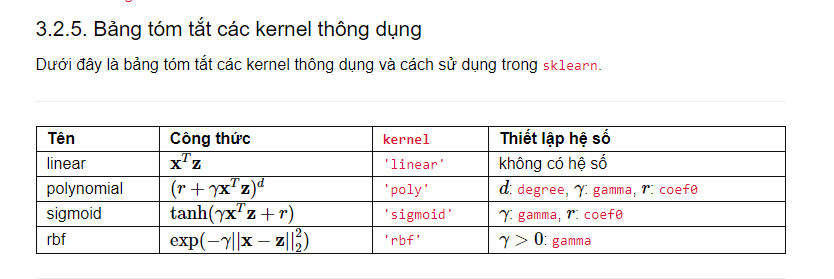

__Default models__

__Khảo sát từng tham số bằng cơm__

In [13]:
C_params = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
kernel_params = ['linear', 'poly', 'rbf'] 
degrees = [1, 2, 3, 4, 5]
gamma = 'scale' #Only for RBF

In [30]:
svm_all_search_space = {
    'kernel': ['poly', 'rbf'],
    'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'degree': [1, 2, 3, 4, 5],
    'gamma': [1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 'scale']
}

search_space_kernel = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

search_space_rbf_gamma_1 = {
    'kernel': ['rbf'],
    'C': [1],
    'gamma': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}

search_space_rbf_gamma_2 = {
    'kernel': ['rbf'],
    'C': [1],
    'gamma': [2e3, 'scale', 5e3, 1e4, 1e5, 1e6, 5e6, 1e7]
}

search_space_rbf_C_2 = {
    'kernel': ['rbf'],
    'C': [1e3, 1e4, 1e5],
    'gamma': [1e6, 1e7]
}

search_space_poly = {
    'kernel': ['poly'],
    'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    # 'C': [1],
    # 'degree': [1, 2, 3, 4],
    'degree': [3],
    # 'gamma': [1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
    'gamma': ['scale']
}

__Sử dụng My Search CV__

In [24]:
# Create the SVM model
svc = SVC(random_state=42, probability=False)
# Create the SimpleGridSearch object
grid_search = SimpleGridSearch(svc, search_space_kernel)
# Fit the simple grid search to your data
grid_search.fit(X_train=X_train_1, y_train=y_train, X_val=X_validation_1, y_val=y_validation)
# Get the best parameters and the corresponding best score
best_params_simple = grid_search.best_params_
# Print the best results from simple grid search
print("Best Parameters (Simple Grid Search):", best_params_simple)
# View all results
grid_search.view_results()

Best Parameters (Simple Grid Search): {'kernel': 'poly'}
Hyperparameters: {'kernel': 'linear'}, Validation Accuracy: 0.44431946006749157
Hyperparameters: {'kernel': 'poly'}, Validation Accuracy: 0.9201349831271091
Hyperparameters: {'kernel': 'rbf'}, Validation Accuracy: 0.9184476940382452
Hyperparameters: {'kernel': 'sigmoid'}, Validation Accuracy: 0.02924634420697413


__Sử dụng GridSearchCV__

In [25]:
# Create the SVM model
svc = SVC(random_state=42, probability=False)
# Create the RandomizedSearchCV object
grid_search = GridSearchCV(svc, search_space_kernel, cv=5, scoring='accuracy', verbose=10)
# Fit the random search to your data
grid_search.fit(X_all_1, y_all)
# Get the best parameters and the corresponding best score
best_params_random = grid_search.best_params_
best_score_random = grid_search.best_score_
# Print the best results from random search
print("Best Parameters (Grid Search):", best_params_random)
print("Best Score (Grid Search):", best_score_random)
# Access the cv_results_ attribute to get detailed information about cross-validated results
cv_results = grid_search.cv_results_
# Print all cross-validated results with their respective parameters
print("\nAll Cross-Validated Results:")
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Mean Score: {mean_score:.4f}, Std Deviation: {std_score:.4f}, Parameters: {params}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START kernel=linear...............................................
[CV 1/5; 1/4] END ................kernel=linear;, score=0.454 total time=   1.8s
[CV 2/5; 1/4] START kernel=linear...............................................
[CV 2/5; 1/4] END ................kernel=linear;, score=0.452 total time=   1.8s
[CV 3/5; 1/4] START kernel=linear...............................................
[CV 3/5; 1/4] END ................kernel=linear;, score=0.461 total time=   1.8s
[CV 4/5; 1/4] START kernel=linear...............................................
[CV 4/5; 1/4] END ................kernel=linear;, score=0.452 total time=   1.8s
[CV 5/5; 1/4] START kernel=linear...............................................
[CV 5/5; 1/4] END ................kernel=linear;, score=0.453 total time=   1.8s
[CV 1/5; 2/4] START kernel=poly.................................................
[CV 1/5; 2/4] END ..................kernel=poly;,

__Sử dụng RandomizedSearchCV__

In [32]:
# Define the search space
search_space = {
    'C': loguniform(1e-3, 1e2),
    'kernel': ['poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': loguniform(1e-3, 3e3)
}
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(svc, verbose=10, param_distributions=svm_all_search_space, n_iter=100, cv=5, random_state=42)
# Fit the random search to your data
random_search.fit(X_all_1, y_all)
# Get the best parameters and the corresponding best score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_
# Print the best results from random search
print("Best Parameters (Random Search):", best_params_random)
print("Best Score (Random Search):", best_score_random)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START C=10000.0, degree=1, gamma=10000.0, kernel=poly...........


## Random forest tunning

## XgBoost tunning